In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from data import *

/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [17]:
df = pd.read_csv('data/beijing_201802_201803_aq.csv')
#df['utc_time'] = pd.to_datetime(df['utc_time'])

In [18]:
stations = list(df.groupby(by='stationId').size().index)

In [9]:
date_to_forc = 10
df = airQualityData('bj', pd.Timestamp('2018-03-%d 00:00:00' % (date_to_forc - 7)),
                    pd.Timestamp('2018-03-%d 23:00:00' % (date_to_forc - 1)))

In [10]:
pm25_df = df[df['station_id'] == stations[0]][['time', 'PM2.5']]

In [11]:
pm25_df.columns = ['ds', 'y']

In [13]:
meo_df = meteorologyGridData('bj', pd.Timestamp('2018-03-%d 00:00:00' % (date_to_forc - 7)),
                             pd.Timestamp('2018-03-%d 23:00:00' % (date_to_forc - 1)))

In [14]:
grid_name = 'beijing_grid_304'

In [15]:
meo_df = meo_df[meo_df['station_id'] == grid_name]
meo_df = meo_df[['time', 'wind_speed']]

In [16]:
meo_df = meo_df.set_index('time')

In [18]:
data_df = pd.concat([pm25_df.set_index('ds'), meo_df], axis=1)
data_df = data_df.reset_index()
data_df.columns = ['ds', 'y', 'wind_speed']

In [19]:
# pm25_df['cap'] = 500 # uncomment if growth='logistic'
m = Prophet(#growth='logistic', # default: linear
            yearly_seasonality=False, weekly_seasonality=False, daily_seasonality='auto',
            #seasonality_prior_scale=0.1, # no use if all seasonality set to False
            changepoint_prior_scale=10) # important argument! Try changing it and then have a look at the figure
m.add_regressor(name='wind_speed', standardize=False)
m.fit(data_df[-24*7:])

/anaconda3/envs/python36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
meo_pred_df = meteorologyGridData('bj', pd.Timestamp('2018-03-%d 00:00:00' % (date_to_forc)),
                                  pd.Timestamp('2018-03-%d 23:00:00' % (date_to_forc + 1)))

In [22]:
meo_pred_df = meo_pred_df[meo_pred_df['station_id'] == grid_name][['time', 'wind_speed']]
meo_pred_df = meo_pred_df.set_index('time')

In [23]:
future = m.make_future_dataframe(periods=48, freq='H', include_history=False)
future = pd.concat([future.set_index('ds'), meo_pred_df], axis=1)
future = future.reset_index()
future.columns = ['ds', 'wind_speed']

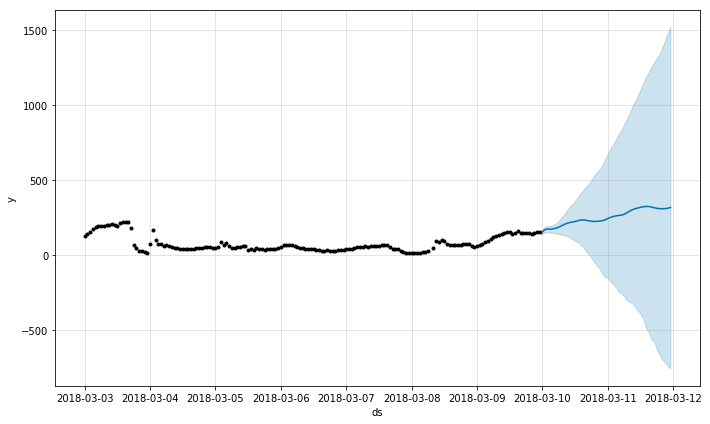

In [24]:
# future['cap'] = 500 # uncomment if growth='logistic'
forecast = m.predict(future)
m.plot(forecast)
res_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [25]:
res_df.tail(48)

,ds,yhat,yhat_lower,yhat_upper
0,2018-03-10 00:00:00,154.798700,138.492184,170.739091
1,2018-03-10 01:00:00,168.419582,150.292123,185.493879
2,2018-03-10 02:00:00,172.280623,152.329641,191.640636
3,2018-03-10 03:00:00,170.185222,146.909520,192.370936
4,2018-03-10 04:00:00,173.826130,146.154232,198.829032
5,2018-03-10 05:00:00,177.773195,143.140650,209.903293
6,2018-03-10 06:00:00,184.546407,137.146619,227.282405
7,2018-03-10 07:00:00,192.977410,134.587715,250.021704
8,2018-03-10 08:00:00,202.322158,129.745412,269.388292
9,2018-03-10 09:00:00,209.895352,126.057617,295.038508


In [28]:
df_actual = airQualityData('bj', pd.Timestamp('2018-03-%d 00:00:00' % (date_to_forc)),
                           pd.Timestamp('2018-03-%d 23:00:00' % (date_to_forc + 1)))
df_actual[df_actual['station_id'] == stations[0]][['time', 'PM2.5']]

,time,PM2.5
0,2018-03-10 00:00:00,154.0
1,2018-03-10 01:00:00,148.0
2,2018-03-10 02:00:00,136.0
3,2018-03-10 03:00:00,130.0
4,2018-03-10 04:00:00,144.0
5,2018-03-10 05:00:00,165.0
6,2018-03-10 06:00:00,164.0
7,2018-03-10 07:00:00,142.0
8,2018-03-10 08:00:00,125.0
9,2018-03-10 09:00:00,113.0
